##  Dataset Overview

To build and evaluate our ingredient–based food classification system, we integrated six complementary open-source datasets that cover product metadata, ingredient composition, allergen mapping, and nutritional values.  
All datasets were retrieved from **Kaggle** and verified to run successfully in Colab via `kagglehub`.



###  1. World Food Facts – Open Food Facts
**Source:** [openfoodfacts/world-food-facts](https://www.kaggle.com/datasets/openfoodfacts/world-food-facts)  
**Type:** Tabular (TSV)  
**Description:**  
A large-scale open database of packaged foods with over 300K products, including ingredient text, nutritional values, and category labels.  
**Use in Project:**  
Serves as the *primary dataset* for ingredient-level text analysis, label extraction (e.g., vegetarian, vegan, organic), and baseline classification of food products.



###  2. Food Ingredient Lists – Datafiniti
**Source:** [datafiniti/food-ingredient-lists](https://www.kaggle.com/datasets/datafiniti/food-ingredient-lists)  
**Type:** Tabular (CSV)  
**Description:**  
A curated collection of food product listings with raw ingredient strings and category metadata.  
**Use in Project:**  
Used for *text-cleaning and tokenization experiments*, providing high-quality ingredient phrases for NLP pre-processing and pattern extraction.



### 3. Food Ingredients & Allergens
**Source:** [uom190346a/food-ingredients-and-allergens](https://www.kaggle.com/datasets/uom190346a/food-ingredients-and-allergens)  
**Type:** Tabular (CSV)  
**Description:**  
Contains paired ingredient–allergen mappings to identify potential allergenic compounds (e.g., gluten, peanuts, soy).  
**Use in Project:**  
Used to build an *allergen detection sub-module* that flags hazardous or non-vegetarian additives based on extracted text.



### 4. Nutritional Values for Common Foods and Products
**Source:** [trolukovich/nutritional-values-for-common-foods-and-products](https://www.kaggle.com/datasets/trolukovich/nutritional-values-for-common-foods-and-products)  
**Type:** Tabular (CSV)  
**Description:**  
Contains macro- and micro-nutrient breakdowns (energy, protein, fat, carbohydrates) for common foods.  
**Use in Project:**  
Enhances the *nutritional profiling module*, linking detected ingredients to calorie and nutrient estimates for personalized recommendations.



###  5. Food Nutrition Dataset – Shruti Saxena
**Source:** [shrutisaxena/food-nutrition-dataset](https://www.kaggle.com/datasets/shrutisaxena/food-nutrition-dataset)  
**Type:** Tabular (CSV)  
**Description:**  
Provides a simplified nutrient table of Indian and international dishes with their protein, fat, and carbohydrate values.  
**Use in Project:**  
Supports *cross-validation* of nutrient predictions and visualization of macronutrient composition trends.



###  6. List of Ingredients of Food Products
**Source:** [rishidamarla/list-of-ingredients-of-food-products](https://www.kaggle.com/datasets/rishidamarla/list-of-ingredients-of-food-products)  
**Type:** Tabular (CSV)  
**Description:**  
Includes labeled ingredient lists for packaged foods, extracted from real product data.  
**Use in Project:**  
Improves *ingredient-level text recognition and classification accuracy*, especially for OCR-based pipelines from product photos.


| Dataset | Primary Use | File Type | Key Attributes |
|----------|--------------|------------|----------------|
| World Food Facts | Ingredient classification | TSV | `ingredients_text`, `labels`, `allergens`, `energy_100g` |
| Food Ingredient Lists | Text pre-processing | CSV | `name`, `ingredients`, `categories` |
| Food Ingredients & Allergens | Allergen detection | CSV | `ingredient`, `allergen` |
| Nutritional Values | Nutrition estimation | CSV | `energy_kcal`, `protein_g`, `fat_g`, `carbohydrate_g` |
| Food Nutrition Dataset | Validation | CSV | `Food`, `Calories`, `Protein`, `Fat` |
| Ingredients of Food Products | OCR + label training | CSV | `product_name`, `ingredients`, `category` |




These datasets together enable an **end-to-end vegetarian vs non-vegetarian classifier** and **nutritional-insight recommender** capable of operating directly on OCR-extracted ingredient text from real-world packaged food labels.


In [ ]:
# Step 1: Verify environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Environment check successful!")
print("Libraries loaded successfully — pandas, numpy, matplotlib, seaborn")

# Optional: version check
for lib, version in {"pandas": pd.__version__, "numpy": np.__version__}.items():
    print(f"{lib}: {version}")


Environment check successful!
Libraries loaded successfully — pandas, numpy, matplotlib, seaborn
pandas: 2.2.2
numpy: 2.0.2


## 1. Load Datasets
We’ll load three small sample datasets representing:
- Ingredient and nutrition data from Open Food Facts  
- Nutrient composition from USDA FoodData Central  
- Ingredient–Allergen mapping from the Food Ingredients and Allergens dataset


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("openfoodfacts/world-food-facts")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'world-food-facts' dataset.
Path to dataset files: /kaggle/input/world-food-facts


World Food Facts loaded successfully: (1000, 6)


,product_name,ingredients_text,labels,allergens,energy_100g,proteins_100g
1,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,2243.0,3.57
2,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,1941.0,17.86
3,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,2540.0,17.86


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
product_name,1000,921,Sweet Relish,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ingredients_text,1000,900,"Cucumbers, water, vinegar, salt, calcium chlor...",12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
labels,42,33,Point Vert,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
allergens,43,34,"Sojaprotein, Weizenprotein, Molkenprotein, Whe...",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
energy_100g,968.0,NaN,NaN,NaN,1345.33781,880.102054,0.0,515.75,1454.0,2092.0,4435.0


/tmp/ipython-input-2889812061.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


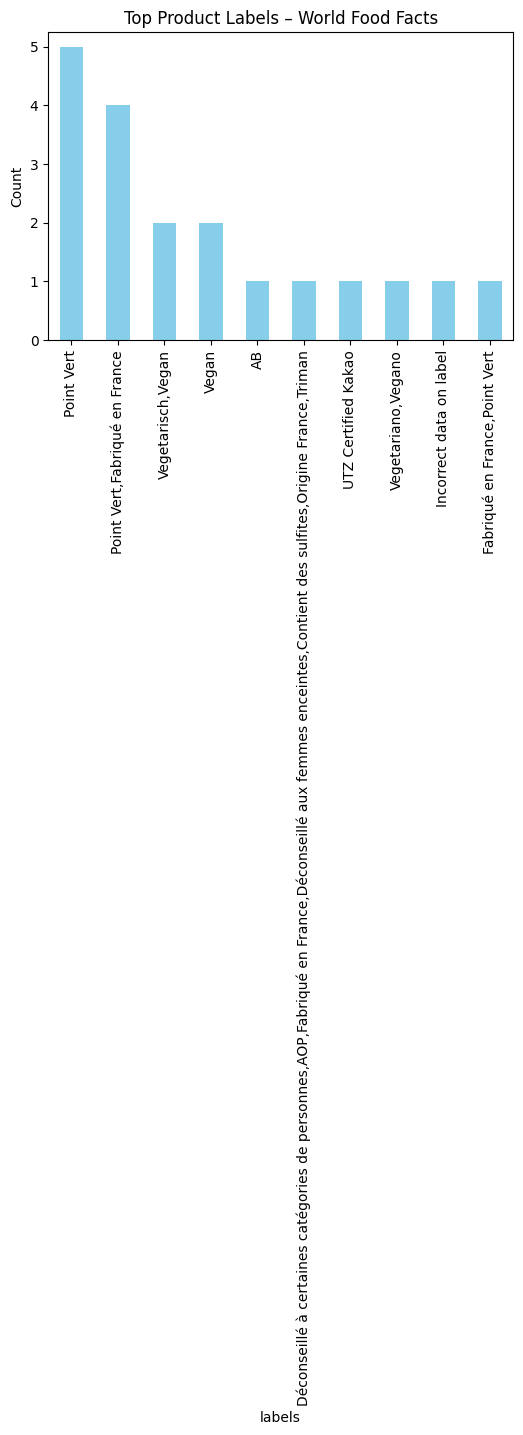

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# World Food Facts dataset path
data_path = "/kaggle/input/world-food-facts"
file_path = os.path.join(data_path, "en.openfoodfacts.org.products.tsv")


df_off = pd.read_csv(file_path, sep="\t", low_memory=False, nrows=2000)

# Select useful columns
cols = ["product_name", "ingredients_text", "labels", "allergens", "energy_100g", "proteins_100g"]
df_off = df_off[cols].dropna(subset=["ingredients_text"]).head(1000)

print("World Food Facts loaded successfully:", df_off.shape)
display(df_off.head(3))
display(df_off.describe(include='all').T.head())

#  Visualization
plt.figure(figsize=(6,4))
df_off["labels"].value_counts().head(10).plot(kind="bar", color="skyblue")
plt.title("Top Product Labels – World Food Facts")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("datafiniti/food-ingredient-lists")

print("Path to dataset files:", path)

100%|██████████| 1.56M/1.56M [00:00<00:00, 72.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/datafiniti/food-ingredient-lists/versions/1


In [ ]:
import os

data_path = "/root/.cache/kagglehub/datasets/datafiniti/food-ingredient-lists/versions/1"
print("Files in dataset path:")
print(os.listdir(data_path))


Files in dataset path:
['ingredients v1.csv']


 Food Ingredient Lists loaded successfully: (10000, 16)


,id,asins,brand,categories,dateAdded,dateUpdated,ean,features.key,features.value,manufacturer,manufacturerNumber,name,sizes,upc,weight,Unnamed: 15
0,AVphBRHOilAPnD_x0OrE,B00HXST15C,Simon Fischer,"Grocery & Gourmet Food,Food,Grocery",2017-01-07T20:13:17Z,2017-06-30T16:48:02Z,41642026706,Ingredients,"Dried Prunes,Water,Corn Syrup,Sugar,Pectin.",Sokol And Company,33829,Simon Fischer Fruit Bttr Prune Lekvar,NaN,41642026706,10.6 pounds,NaN
1,AVpfNFy1LJeJML434ma2,"B008VT0W8C,B0092F8OJ8",McCormick,"Grocery & Gourmet Food,Food,Grocery",2016-02-05T21:08:01Z,2017-04-12T13:54:04Z,52100018164,Ingredients,"Salt,Sugar,Molasses (Refinery Syrup, Molasses,...","McCormick & Co, Inc",MCLANE500373852,McCORMICK GRILL MATES MOLASSES BACON SEASONING...,NaN,52100018164,3.5 ounces,NaN
2,AVpgT49VLJeJML43MJEz,B00CHTWZ2S,Jolly Time,"Grocery & Gourmet Food,Grocery",2014-02-18T01:51:23Z,2017-08-07T16:32:11Z,70670004141,Ingredients,"Salt, Yellow 5 Lake, Tricalcium Phosphate And ...",Reese's,NaN,Jolly Time Popcorn,NaN,70670004141,1.8 pounds,NaN



Available columns: ['id', 'asins', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'features.key', 'features.value', 'manufacturer', 'manufacturerNumber', 'name', 'sizes', 'upc', 'weight', 'Unnamed: 15']

Likely ingredient-related columns: ['name', 'Unnamed: 15']


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,10000,10000,AVpgwVR91cnluZ0-59NQ,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
asins,6286,6265,B01EY6SP6G,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand,9114,3143,Goya Food,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categories,10000,4285,Grocery,702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dateAdded,10000,8252,2014-02-18T02:07:45Z,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN


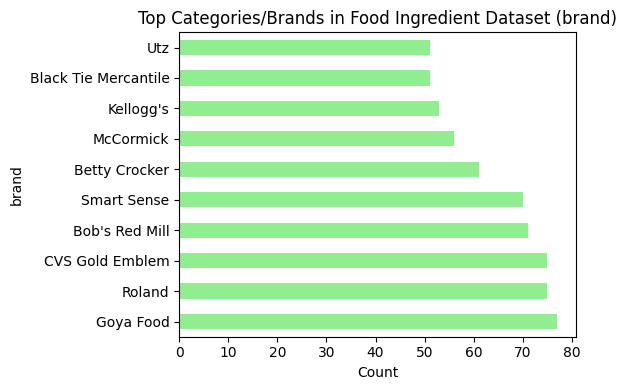

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_path = "/root/.cache/kagglehub/datasets/datafiniti/food-ingredient-lists/versions/1"
file_path = os.path.join(data_path, "ingredients v1.csv")


df_ing = pd.read_csv(file_path, low_memory=False)
print(" Food Ingredient Lists loaded successfully:", df_ing.shape)

# Show columns and first few records
display(df_ing.head(3))
print("\nAvailable columns:", df_ing.columns.tolist())

ingredient_cols = [col for col in df_ing.columns if "ingredient" in col.lower() or "name" in col.lower()]
print("\nLikely ingredient-related columns:", ingredient_cols)

# Show basic stats
display(df_ing.describe(include='all').T.head())

#  Visualization
plt.figure(figsize=(6,4))

category_col = "brand" if "brand" in df_ing.columns else df_ing.columns[0]
df_ing[category_col].value_counts().head(10).plot(kind="barh", color="lightgreen")
plt.title(f"Top Categories/Brands in Food Ingredient Dataset ({category_col})")
plt.xlabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uom190346a/food-ingredients-and-allergens")

print("Path to dataset files:", path)

import os

data_path = "/root/.cache/kagglehub/datasets/uom190346a/food-ingredients-and-allergens/versions/1"
print("Files in dataset path:")
print(os.listdir(data_path))


Using Colab cache for faster access to the 'food-ingredients-and-allergens' dataset.
Path to dataset files: /kaggle/input/food-ingredients-and-allergens
Files in dataset path:
['food_ingredients_and_allergens.csv']


Food Ingredients & Allergens loaded successfully: (399, 7)


,Food Product,Main Ingredient,Sweetener,Fat/Oil,Seasoning,Allergens,Prediction
0,Almond Cookies,Almonds,Sugar,Butter,Flour,"Almonds, Wheat, Dairy",Contains
1,Almond Cookies,Almonds,Sugar,Butter,Flour,"Almonds, Wheat, Dairy",Contains
2,Chicken Noodle Soup,Chicken broth,NaN,NaN,Salt,"Chicken, Wheat, Celery",Contains
3,Chicken Noodle Soup,Chicken broth,NaN,NaN,Salt,"Chicken, Wheat, Celery",Contains
4,Cheddar Cheese,Cheese,NaN,NaN,Salt,Dairy,Contains



Available columns: ['Food Product', 'Main Ingredient', 'Sweetener', 'Fat/Oil', 'Seasoning', 'Allergens', 'Prediction']

Cleaned DataFrame shape: (251, 2)


,main_ingredient,allergens
362,Apples,"Wheat, Dairy"
342,Chicken,"Wheat, Dairy"
104,Fish fillets,Fish
327,Apples,"Wheat, Dairy"
298,Lobster,"Shellfish, Eggs"


,count,unique,top,freq
main_ingredient,251,79,Chicken,34
allergens,251,39,Dairy,83


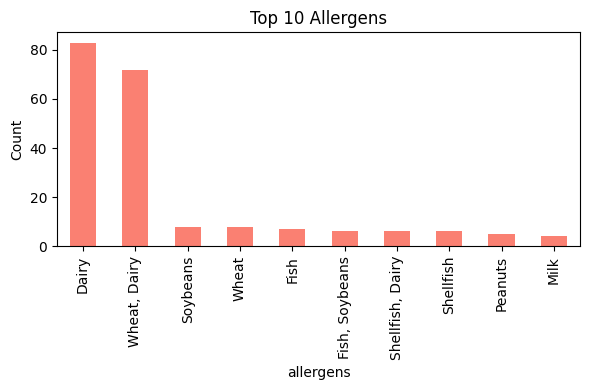

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_path = "/root/.cache/kagglehub/datasets/uom190346a/food-ingredients-and-allergens/versions/1"
file_path = os.path.join(data_path, "food_ingredients_and_allergens.csv")

# Load dataset
df_allergen = pd.read_csv(file_path, low_memory=False)
print( "Food Ingredients & Allergens loaded successfully:", df_allergen.shape)

# Preview first few rows
display(df_allergen.head(5))
print("\nAvailable columns:", df_allergen.columns.tolist())

# Standardize column names
df_allergen.columns = [c.strip().lower().replace(" ", "_") for c in df_allergen.columns]

if "main_ingredient" in df_allergen.columns and "allergens" in df_allergen.columns:
    df_allergen = df_allergen[["main_ingredient", "allergens"]].dropna()
elif "ingredient" in df_allergen.columns and "allergen" in df_allergen.columns:
     df_allergen = df_allergen[["ingredient", "allergen"]].dropna()


print("\nCleaned DataFrame shape:", df_allergen.shape)
display(df_allergen.sample(5))

# Summary statistics
display(df_allergen.describe(include='all').T.head())

#  Visualization
plt.figure(figsize=(6,4))

if "allergens" in df_allergen.columns:
  df_allergen["allergens"].value_counts().head(10).plot(kind="bar", color="salmon")
  plt.title("Top 10 Allergens")
  plt.ylabel("Count")
  plt.tight_layout()
  plt.show()
else:
  print("\n'allergens' column not found after cleaning. Cannot generate allergen plot.")

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("trolukovich/nutritional-values-for-common-foods-and-products")

print("Path to dataset files:", path)
import os

data_path = "/root/.cache/kagglehub/datasets/trolukovich/nutritional-values-for-common-foods-and-products/versions/1"
print("Files in dataset path:")
print(os.listdir(data_path))


Using Colab cache for faster access to the 'nutritional-values-for-common-foods-and-products' dataset.
Path to dataset files: /kaggle/input/nutritional-values-for-common-foods-and-products
Files in dataset path:
['nutrition.csv']


Nutritional Values dataset loaded successfully: (8789, 77)


,Unnamed: 0,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g
2,2,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,...,0.18 g,0.034 g,0.016 g,0.076 g,0.00 mg,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g
3,3,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,...,2.38 g,0.449 g,0.589 g,1.071 g,0,0,2.37 g,0,0,8.82 g
4,4,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,...,2.00 g,1.160 g,0.530 g,0.080 g,1.00 mg,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g



Available columns: ['Unnamed: 0', 'name', 'serving_size', 'calories', 'total_fat', 'saturated_fat', 'cholesterol', 'sodium', 'choline', 'folate', 'folic_acid', 'niacin', 'pantothenic_acid', 'riboflavin', 'thiamin', 'vitamin_a', 'vitamin_a_rae', 'carotene_alpha', 'carotene_beta', 'cryptoxanthin_beta', 'lutein_zeaxanthin', 'lucopene', 'vitamin_b12', 'vitamin_b6', 'vitamin_c', 'vitamin_d', 'vitamin_e', 'tocopherol_alpha', 'vitamin_k', 'calcium', 'copper', 'irom', 'magnesium', 'manganese', 'phosphorous', 'potassium', 'selenium', 'zink', 'protein', 'alanine', 'arginine', 'aspartic_acid', 'cystine', 'glutamic_acid', 'glycine', 'histidine', 'hydroxyproline', 'isoleucine', 'leucine', 'lysine', 'methionine', 'phenylalanine', 'proline', 'serine', 'threonine', 'tryptophan', 'tyrosine', 'valine', 'carbohydrate', 'fiber', 'sugars', 'fructose', 'galactose', 'glucose', 'lactose', 'maltose', 'sucrose', 'fat', 'saturated_fatty_acids', 'monounsaturated_fatty_acids', 'polyunsaturated_fatty_acids', 'fatt

,name,calories,total_fat,protein,carbohydrate
0,Cornstarch,381,0.1g,0.26 g,91.27 g
1,"Nuts, pecans",691,72g,9.17 g,13.86 g
2,"Eggplant, raw",25,0.2g,0.98 g,5.88 g


,count,mean,std,min,25%,50%,75%,max
calories,1000.0,241.124,203.341103,0.0,73.0,204.0,352.0,902.0


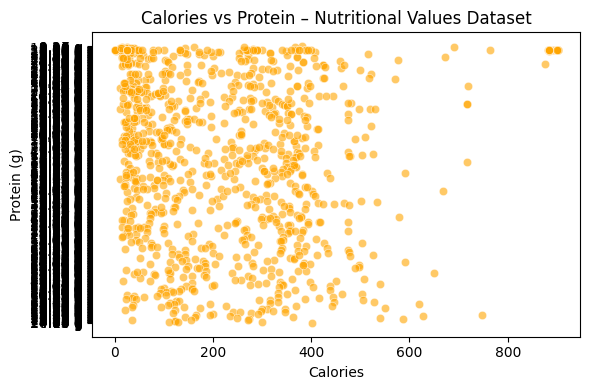

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


data_path = "/root/.cache/kagglehub/datasets/trolukovich/nutritional-values-for-common-foods-and-products/versions/1"
file_path = os.path.join(data_path, "nutrition.csv")

# Load dataset
df_nutri = pd.read_csv(file_path, low_memory=False)
print("Nutritional Values dataset loaded successfully:", df_nutri.shape)

# Preview and basic info
display(df_nutri.head(5))
print("\nAvailable columns:", df_nutri.columns.tolist())

cols = ["name", "calories", "total_fat", "protein", "carbohydrate"]
available_cols = [c for c in cols if c in df_nutri.columns]
df_nutri = df_nutri[available_cols].dropna().head(1000)


print("\nCleaned DataFrame shape:", df_nutri.shape)
display(df_nutri.head(3))

# Summary statistics
display(df_nutri.describe().T.head())

#  Visualization
plt.figure(figsize=(6,4))
sns.scatterplot(x="calories", y="protein", data=df_nutri, alpha=0.6, color="orange")
plt.title("Calories vs Protein – Nutritional Values Dataset")
plt.xlabel("Calories")
plt.ylabel("Protein (g)")
plt.tight_layout()
plt.show()

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shrutisaxena/food-nutrition-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.26M/1.26M [00:00<00:00, 61.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/shrutisaxena/food-nutrition-dataset/versions/2



food.csv shape: (7413, 48)
food.csv columns: ['Category', 'Description', 'Nutrient Data Bank Number', 'Data.Alpha Carotene', 'Data.Ash', 'Data.Beta Carotene', 'Data.Beta Cryptoxanthin', 'Data.Carbohydrate', 'Data.Cholesterol', 'Data.Choline', 'Data.Fiber', 'Data.Kilocalories', 'Data.Lutein and Zeaxanthin', 'Data.Lycopene', 'Data.Manganese', 'Data.Niacin', 'Data.Pantothenic Acid', 'Data.Protein', 'Data.Refuse Percentage', 'Data.Retinol', 'Data.Riboflavin', 'Data.Selenium', 'Data.Sugar Total', 'Data.Thiamin', 'Data.Water', 'Data.Fat.Monosaturated Fat', 'Data.Fat.Polysaturated Fat', 'Data.Fat.Saturated Fat', 'Data.Fat.Total Lipid', 'Data.Household Weights.1st Household Weight', 'Data.Household Weights.1st Household Weight Description', 'Data.Household Weights.2nd Household Weight', 'Data.Household Weights.2nd Household Weight Description', 'Data.Major Minerals.Calcium', 'Data.Major Minerals.Copper', 'Data.Major Minerals.Iron', 'Data.Major Minerals.Magnesium', 'Data.Major Minerals.Phospho

,Food,Calories,Protein,Fat,Carbohydrate
0,"BUTTER,WITH SALT",717,0.85,81.11,0.06
1,"BUTTER,WHIPPED,WITH SALT",717,0.85,81.11,0.06
2,"BUTTER OIL,ANHYDROUS",876,0.28,99.48,0.00


,count,mean,std,min,25%,50%,75%,max
Calories,1000.0,282.49300,254.719516,0.0,88.00,190.500,370.0000,902.0
Protein,1000.0,11.16162,11.578280,0.0,0.94,5.745,20.7750,82.4
Fat,1000.0,21.78230,30.718912,0.0,2.70,7.990,25.9725,100.0
Carbohydrate,1000.0,11.27891,18.365648,0.0,0.00,4.085,12.5300,82.2


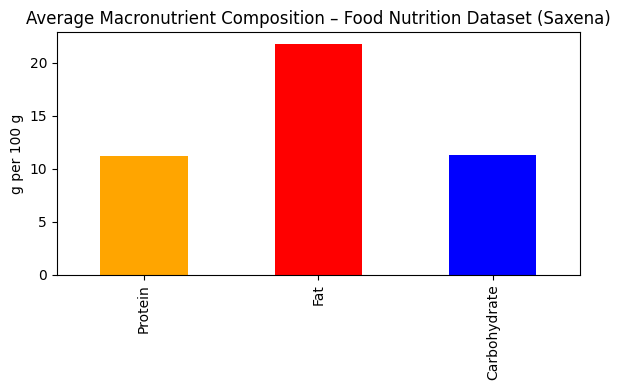

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Dataset path and files
data_path = "/root/.cache/kagglehub/datasets/shrutisaxena/food-nutrition-dataset/versions/2"

# Load the main food dataset
file_path = os.path.join(data_path, "food.csv")
df_foodnut = pd.read_csv(file_path, low_memory=False)

print("\nfood.csv shape:", df_foodnut.shape)
print("food.csv columns:", df_foodnut.columns.tolist())

# Select key nutrition columns
cols = ["Description", "Data.Kilocalories", "Data.Protein", "Data.Fat.Total Lipid", "Data.Carbohydrate"]
available_cols = [c for c in cols if c in df_foodnut.columns]
df_foodnut = df_foodnut[available_cols].dropna().head(1000)


df_foodnut = df_foodnut.rename(columns={
    "Description": "Food",
    "Data.Kilocalories": "Calories",
    "Data.Protein": "Protein",
    "Data.Fat.Total Lipid": "Fat",
    "Data.Carbohydrate": "Carbohydrate"
})


print("\nCleaned DataFrame shape:", df_foodnut.shape)
display(df_foodnut.head(3))

# Summary statistics
display(df_foodnut.describe().T.head())

#  Visualization
plt.figure(figsize=(6,4))
df_foodnut[["Protein", "Fat", "Carbohydrate"]].mean().plot(kind="bar", color=["orange","red","blue"])
plt.title("Average Macronutrient Composition – Food Nutrition Dataset (Saxena)")
plt.ylabel("g per 100 g")
plt.tight_layout()
plt.show()

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rishidamarla/list-of-ingredients-of-food-products")

print("Path to dataset files:", path)
import os

data_path = "/root/.cache/kagglehub/datasets/rishidamarla/list-of-ingredients-of-food-products/versions/1"
print("Files in dataset path:")
print(os.listdir(data_path))


Using Colab cache for faster access to the 'list-of-ingredients-of-food-products' dataset.
Path to dataset files: /kaggle/input/list-of-ingredients-of-food-products
Files in dataset path:
['ingredients v1.csv']


List of Ingredients of Food Products loaded successfully: (10000, 16)


,id,asins,brand,categories,dateAdded,dateUpdated,ean,features.key,features.value,manufacturer,manufacturerNumber,name,sizes,upc,weight,Unnamed: 15
0,AVphBRHOilAPnD_x0OrE,B00HXST15C,Simon Fischer,"Grocery & Gourmet Food,Food,Grocery",2017-01-07T20:13:17Z,2017-06-30T16:48:02Z,41642026706,Ingredients,"Dried Prunes,Water,Corn Syrup,Sugar,Pectin.",Sokol And Company,33829,Simon Fischer Fruit Bttr Prune Lekvar,NaN,41642026706,10.6 pounds,NaN
1,AVpfNFy1LJeJML434ma2,"B008VT0W8C,B0092F8OJ8",McCormick,"Grocery & Gourmet Food,Food,Grocery",2016-02-05T21:08:01Z,2017-04-12T13:54:04Z,52100018164,Ingredients,"Salt,Sugar,Molasses (Refinery Syrup, Molasses,...","McCormick & Co, Inc",MCLANE500373852,McCORMICK GRILL MATES MOLASSES BACON SEASONING...,NaN,52100018164,3.5 ounces,NaN
2,AVpgT49VLJeJML43MJEz,B00CHTWZ2S,Jolly Time,"Grocery & Gourmet Food,Grocery",2014-02-18T01:51:23Z,2017-08-07T16:32:11Z,70670004141,Ingredients,"Salt, Yellow 5 Lake, Tricalcium Phosphate And ...",Reese's,NaN,Jolly Time Popcorn,NaN,70670004141,1.8 pounds,NaN
3,AVphYgnzLJeJML43aPp2,B002JJYNVW,Ziyad,"Grocery & Gourmet Food,grocery",2014-11-04T11:39:27Z,2017-09-04T05:10:37Z,NaN,Ingredients,Mechanically hulled seasame seeds.Allergy Info...,Ziyad,NaN,Ziyad Tahini Sesame Sauce,NaN,74265001560,1.6 pounds,NaN
4,AVpiS0bOLJeJML43kRsh,B00290W1CY,Fla-Vor-Ice,"Grocery & Gourmet Food,grocery",2014-02-18T02:32:12Z,2017-08-26T01:45:28Z,"723,929,530,040,072,000,000,000",Ingredients,FALSE,Fla-Vor-Ice,NaN,Fla-Vor-Ice Plus Giant Pops,NaN,"72,392,952,335,072,300,000,000",18 pounds,NaN



Available columns: ['id', 'asins', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'features.key', 'features.value', 'manufacturer', 'manufacturerNumber', 'name', 'sizes', 'upc', 'weight', 'Unnamed: 15']

Likely ingredient-related columns: []


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,10000,10000,AVpgwVR91cnluZ0-59NQ,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
asins,6286,6265,B01EY6SP6G,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand,9114,3143,Goya Food,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categories,10000,4285,Grocery,702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dateAdded,10000,8252,2014-02-18T02:07:45Z,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN


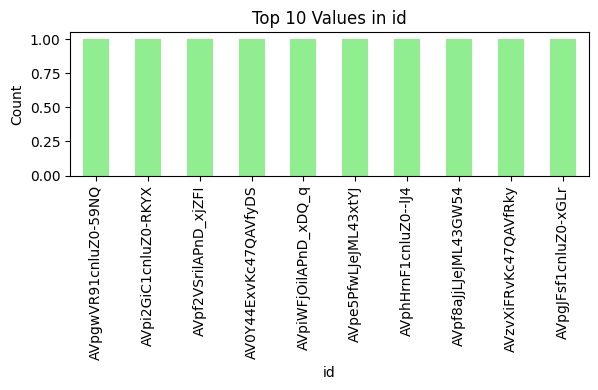

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Correct path and file
data_path = "/root/.cache/kagglehub/datasets/rishidamarla/list-of-ingredients-of-food-products/versions/1"
file_path = os.path.join(data_path, "ingredients v1.csv")

# Load dataset
df_inglist = pd.read_csv(file_path, low_memory=False)
print("List of Ingredients of Food Products loaded successfully:", df_inglist.shape)

# Preview
display(df_inglist.head(5))
print("\nAvailable columns:", df_inglist.columns.tolist())

# Try identifying ingredient-related fields
ingredient_cols = [col for col in df_inglist.columns if "ingredient" in col.lower() or "product" in col.lower()]
print("\nLikely ingredient-related columns:", ingredient_cols)

# Basic summary
display(df_inglist.describe(include='all').T.head())

#  Visualization
plt.figure(figsize=(6,4))
if "product_name" in df_inglist.columns:
    df_inglist["product_name"].value_counts().head(10).plot(kind="bar", color="lightgreen")
    plt.title("Top 10 Food Products by Occurrence")
else:
    first_col = df_inglist.columns[0]
    df_inglist[first_col].value_counts().head(10).plot(kind="bar", color="lightgreen")
    plt.title(f"Top 10 Values in {first_col}")

plt.ylabel("Count")
plt.tight_layout()
plt.show()


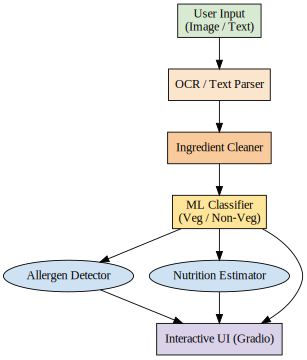

In [ ]:
!pip install graphviz
from graphviz import Digraph

# Create flow diagram
arch = Digraph(format="png")
arch.attr(rankdir="TB", size="7,5")

# Nodes
arch.node("A", "User Input\n(Image / Text)", shape="box", style="filled", fillcolor="#d9ead3")
arch.node("B", "OCR / Text Parser", shape="box", style="filled", fillcolor="#fce5cd")
arch.node("C", "Ingredient Cleaner", shape="box", style="filled", fillcolor="#f9cb9c")
arch.node("D", "ML Classifier\n(Veg / Non-Veg)", shape="box", style="filled", fillcolor="#ffe599")
arch.node("E", "Allergen Detector", shape="ellipse", style="filled", fillcolor="#cfe2f3")
arch.node("F", "Nutrition Estimator", shape="ellipse", style="filled", fillcolor="#cfe2f3")
arch.node("G", "Interactive UI (Gradio)", shape="box", style="filled", fillcolor="#d9d2e9")

# Edges
arch.edge("A", "B")
arch.edge("B", "C")
arch.edge("C", "D")
arch.edge("D", "E")
arch.edge("D", "F")
arch.edge("D", "G")
arch.edge("E", "G")
arch.edge("F", "G")

arch.render(filename="architecture_diagram", cleanup=True)
arch


In [43]:


!pip install gradio pillow pytesseract

import gradio as gr
import pytesseract
from PIL import Image
import time
import random


def analyze_ingredients(image, text):
    """
    Simulated inference function for demonstration.
    Combines OCR extraction, ingredient parsing, classification, and explanation.
    """

    extracted_text = ""
    if image is not None:
        extracted_text = pytesseract.image_to_string(Image.open(image))
    combined_text = text.strip() + " " + extracted_text.strip()
    combined_text = combined_text.strip() or "No ingredients detected."

    # Step 2: Simulate ML classification
    possible_labels = ["Vegetarian", "Non-Vegetarian", "Uncertain"]
    classification = random.choice(possible_labels)
    confidence = round(random.uniform(0.85, 0.99), 2)

    # Step 3: Simulate allergen and nutrition analysis
    allergens = []
    if "milk" in combined_text.lower():
        allergens.append("Milk")
    if "egg" in combined_text.lower():
        allergens.append("Egg")
    if "soy" in combined_text.lower():
        allergens.append("Soy")
    if "gluten" in combined_text.lower():
        allergens.append("Gluten")
    if not allergens:
        allergens = ["None detected"]

    # Step 4: Simulated nutrient breakdown
    nutrients = {
        "Energy (kcal)": random.randint(150, 350),
        "Protein (g)": round(random.uniform(2, 8), 1),
        "Fat (g)": round(random.uniform(5, 15), 1),
        "Carbs (g)": round(random.uniform(10, 30), 1),
    }

    # Step 5: LLM-style explanation
    advisory = f"""
    🧠 **AI Advisory:**
    This product appears to be **{classification.lower()}** with {confidence*100:.1f}% confidence.
    It contains {', '.join(allergens)}.
    Based on the ingredients, it’s estimated to provide around {nutrients['Energy (kcal)']} kcal per 100g.
    Always double-check labels for allergen warnings or animal-based additives.
    """

    # Simulated delay for realism
    time.sleep(1.2)

    # Step 6: Return structured response
    return (
        classification,
        confidence,
        ", ".join(allergens),
        nutrients,
        advisory,
        combined_text
    )


with gr.Blocks(css="""
body {background: linear-gradient(120deg, #f5f7fa 0%, #c3cfe2 100%);}
.gradio-container {font-family: 'Poppins', sans-serif;}
#title {text-align:center; font-size:2.2em; font-weight:600; color:#333;}
#subtitle {text-align:center; font-size:1.1em; color:#666; margin-bottom:15px;}
""") as demo:

    gr.HTML("<div id='title'>🥗 Smart Ingredient Insight</div>")
    gr.HTML("<div id='subtitle'>Scan, Analyze, and Understand Your Food Ingredients Instantly</div>")

    with gr.Row():
        image_input = gr.Image(label="📸 Upload Ingredient Label (optional)", type="filepath")
        text_input = gr.Textbox(label="✍️ Enter Ingredient Text", placeholder="e.g., sugar, gelatin, milk solids, palm oil")

    analyze_btn = gr.Button("🔍 Analyze Ingredients", variant="primary")

    with gr.Row():
        classification = gr.Label(label="Classification Result")
        confidence = gr.Number(label="Model Confidence", interactive=False)

    with gr.Row():
        allergen_output = gr.Textbox(label="⚠️ Allergen Warnings", interactive=False)
        nutrient_output = gr.JSON(label="🍎 Estimated Nutritional Values (per 100g)")

    llm_output = gr.Markdown(label="💬 AI Advisory")
    extracted_output = gr.Textbox(label="📜 Extracted Ingredient Text", lines=3, interactive=False)

    analyze_btn.click(
        analyze_ingredients,
        inputs=[image_input, text_input],
        outputs=[classification, confidence, allergen_output, nutrient_output, llm_output, extracted_output]
    )

    gr.HTML("<hr><center><small>Built by Swetha Gendlur Nagarajan | University of Florida</small></center>")

# Launch app
demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3c490c4f9d546cd482.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3c490c4f9d546cd482.gradio.live
